In [1]:
# To support both python 2 and python 3
# 让这份笔记同步支持 python 2 和 python 3
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
#使用statsmodels便于统计分析数据
import statsmodels.api as sm
import statsmodels.formula.api as smf
#使用sklearn便于预测（机器学习）
from sklearn import linear_model
#使用patsy便于生成模型
import patsy

**10. This question relates to the College data set.
(a) Split the data into a training set and a test set. Using out-of-state
tuition as the response and the other variables as the predictors,
perform forward stepwise selection on the training set in order
to identify a satisfactory model that uses just a subset of the
predictors.**

In [3]:
College = pd.read_csv("data/College.csv")
College.head()

,Unnamed: 0,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [4]:
#实现一个按照RSS（或者其他评估）来量化的regsubsets函数
import itertools
def regsubsets(model,dataset,nvmax = 8,method = 'full',scale = 'rss'):
    y,X = patsy.dmatrices(model, data = dataset, return_type="dataframe")
    X_columns = list(X.columns)
    try:
        X_columns.remove('Intercept')
    except:
        pass
    if nvmax > len(X_columns):
        nvmax = len(X_columns)
    all_data_dict = {}
    if method == 'full':
        for nv in range(1,nvmax + 1):
            nv_scale = None
            nv_result = {}
            for X_columns_nv in itertools.combinations(X_columns,nv):
                X_columns_nv = list(X_columns_nv)
                X_model = sm.add_constant(X[X_columns_nv])
                results = sm.OLS(y, X_model).fit()
                nv_result['rss'] = results.ssr
                nv_result['rsq'] = -results.rsquared
                nv_result['adjr2'] = -results.rsquared_adj
                nv_result['cp'] = results.aic
                nv_result['bic'] = results.bic
                if nv_scale == None or nv_scale > nv_result[scale]:
                    nv_scale = nv_result[scale]
                    nv_X_columns = X_columns_nv
            X_model = sm.add_constant(X[nv_X_columns])
            results = sm.OLS(y, X_model).fit()
            all_data_dict[nv] = {}
            all_data_dict[nv]['X_columns'] = nv_X_columns
            all_data_dict[nv]['rss'] = results.ssr
            all_data_dict[nv]['rsq'] = results.rsquared
            all_data_dict[nv]['adjr2'] = results.rsquared_adj
            all_data_dict[nv]['cp'] = results.aic
            all_data_dict[nv]['bic'] = results.bic
            all_data_dict[nv]['params'] = results.params
    elif method == 'forward':
        all_data_dict[0] = {}
        all_data_dict[0]['X_columns'] = []
        for nv in range(1,nvmax + 1):
            nv_scale = None
            nv_result = {}
            X_columns_others = X_columns.copy()
            for column_value in all_data_dict[nv - 1]['X_columns']:
                X_columns_others.remove(column_value)
            for column_value in X_columns_others:
                X_columns_nv = all_data_dict[nv - 1]['X_columns'].copy()
                X_columns_nv.append(column_value)
                X_model = sm.add_constant(X[X_columns_nv])
                results = sm.OLS(y, X_model).fit()
                nv_result['rss'] = results.ssr
                nv_result['rsq'] = -results.rsquared
                nv_result['adjr2'] = -results.rsquared_adj
                nv_result['cp'] = results.aic
                nv_result['bic'] = results.bic
                if nv_scale == None or nv_scale > nv_result[scale]:
                    nv_scale = nv_result[scale]
                    nv_X_columns = X_columns_nv
            X_model = sm.add_constant(X[nv_X_columns])
            results = sm.OLS(y, X_model).fit()
            all_data_dict[nv] = {}
            all_data_dict[nv]['X_columns'] = nv_X_columns
            all_data_dict[nv]['rss'] = results.ssr
            all_data_dict[nv]['rsq'] = results.rsquared
            all_data_dict[nv]['adjr2'] = results.rsquared_adj
            all_data_dict[nv]['cp'] = results.aic
            all_data_dict[nv]['bic'] = results.bic
            all_data_dict[nv]['params'] = results.params
        del all_data_dict[0]
    elif method == 'backward':
        for nv in reversed(range(1,len(X_columns) + 1)):
            nv_scale = None
            nv_result = {}
            if nv == len(X_columns):
                nv_X_columns = X_columns
            else:
                for column_value in all_data_dict[nv + 1]['X_columns']:
                    X_columns_nv = all_data_dict[nv + 1]['X_columns'].copy()
                    X_columns_nv.remove(column_value)
                    X_model = sm.add_constant(X[X_columns_nv])
                    results = sm.OLS(y, X_model).fit()
                    nv_result['rss'] = results.ssr
                    nv_result['rsq'] = -results.rsquared
                    nv_result['adjr2'] = -results.rsquared_adj
                    nv_result['cp'] = results.aic
                    nv_result['bic'] = results.bic
                    if nv_scale == None or nv_scale > nv_result[scale]:
                        nv_scale = nv_result[scale]
                        nv_X_columns = X_columns_nv
            X_model = sm.add_constant(X[nv_X_columns])
            results = sm.OLS(y, X_model).fit()
            all_data_dict[nv] = {}
            all_data_dict[nv]['X_columns'] = nv_X_columns
            all_data_dict[nv]['rss'] = results.ssr
            all_data_dict[nv]['rsq'] = results.rsquared
            all_data_dict[nv]['adjr2'] = results.rsquared_adj
            all_data_dict[nv]['cp'] = results.aic
            all_data_dict[nv]['bic'] = results.bic
            all_data_dict[nv]['params'] = results.params
            for nv in range(nvmax + 1,len(X_columns) + 1):
                del all_data_dict[nv]
    return pd.DataFrame(all_data_dict).T.sort_index()

In [5]:
#patsy.dmatrices不支持列名含.，将其转化为_
College_rename = College.copy()
for column_value in College.columns:
    if '.' in column_value:
        column_value_replace = column_value.replace(".", "_")
        College_rename.rename(columns={column_value:column_value_replace},inplace=True)

In [6]:
columns_value = '1'
for column_value in College_rename.columns:
    columns_value = columns_value + '+' + column_value
model = 'Outstate ~ {} - Outstate - Unnamed: 0'.format(columns_value)
reg = regsubsets(model,College_rename,nvmax = 20,method = 'forward')

c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [7]:
reg

,X_columns,rss,rsq,adjr2,cp,bic,params
1,[Expend],6.87457e+09,0.452631,0.451925,14637.7,14647,const 5433.512276 Expend 0.518330 dt...
2,"[Expend, Private[T.Yes]]",4.94382e+09,0.606362,0.605345,14383.5,14397.5,const 3550.327247 Expend ...
3,"[Expend, Private[T.Yes], Room_Board]",3.98629e+09,0.682602,0.68137,14218.2,14236.8,const -145.014030 Expend ...
4,"[Expend, Private[T.Yes], Room_Board, perc_alumni]",3.52653e+09,0.719209,0.717754,14125,14148.3,const -786.545484 Expend ...
5,"[Expend, Private[T.Yes], Room_Board, perc_alum...",3.30277e+09,0.737026,0.735321,14076.1,14104,const -2864.632562 Expend ...
6,"[Expend, Private[T.Yes], Room_Board, perc_alum...",3.17349e+09,0.747319,0.74535,14047,14079.6,const -3553.234527 Expend ...
7,"[Expend, Private[T.Yes], Room_Board, perc_alum...",3.14149e+09,0.749868,0.747591,14041.2,14078.4,const -2858.661855 Expend ...
8,"[Expend, Private[T.Yes], Room_Board, perc_alum...",3.11453e+09,0.752014,0.749431,14036.5,14078.4,const -3427.021798 Expend ...
9,"[Expend, Private[T.Yes], Room_Board, perc_alum...",3.09394e+09,0.753654,0.750763,14033.3,14079.9,const -2320.343234 Expend ...
10,"[Expend, Private[T.Yes], Room_Board, perc_alum...",3.07513e+09,0.755151,0.751954,14030.6,14081.8,const -2089.122700 Expend ...


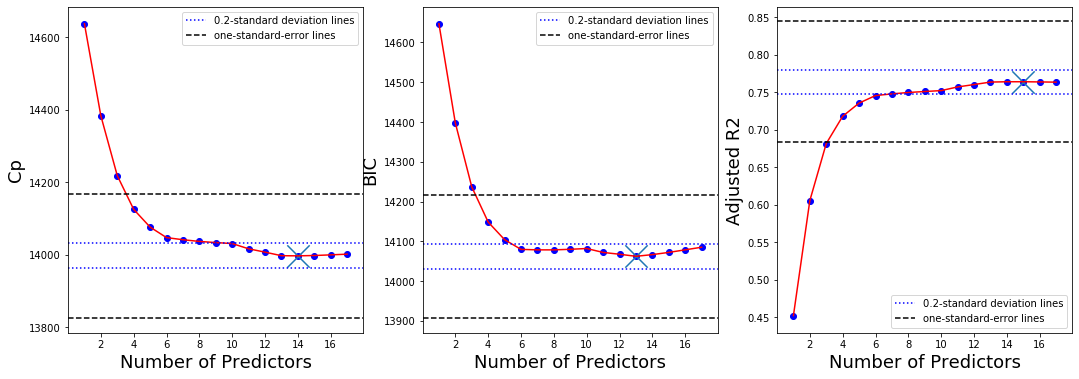

In [8]:
plt.figure(figsize=(18, 6))
x_plot = range(1,18)
plt.subplot(131)
plt.plot(x_plot,reg['cp'],'r-')
plt.scatter(x_plot,reg['cp'],color = 'b')
plt.scatter(reg['cp'].astype('float64').idxmin(),reg['cp'].min(),marker = 'x',s=500)
plt.xlabel(u"Number of Predictors", fontsize=18)
plt.ylabel(u"Cp", fontsize=18)
plt.axhline(reg['cp'].min() + reg['cp'].std() * 0.2,color = 'b',linestyle = ':',label = '0.2-standard deviation lines')
plt.axhline(reg['cp'].min() - reg['cp'].std() * 0.2,color = 'b',linestyle = ':')
plt.axhline(reg['cp'].min() + reg['cp'].std() * 1,color = 'black',linestyle = '--',label = 'one-standard-error lines')
plt.axhline(reg['cp'].min() - reg['cp'].std() * 1,color = 'black',linestyle = '--')
plt.legend()
plt.subplot(132)
plt.plot(x_plot,reg['bic'],'r-')
plt.scatter(x_plot,reg['bic'],color = 'b')
plt.scatter(reg['bic'].astype('float64').idxmin(),reg['bic'].min(),marker = 'x',s=500)
plt.xlabel(u"Number of Predictors", fontsize=18)
plt.ylabel(u"BIC", fontsize=18)
plt.axhline(reg['bic'].min() + reg['bic'].std() * 0.2,color = 'b',linestyle = ':',label = '0.2-standard deviation lines')
plt.axhline(reg['bic'].min() - reg['bic'].std() * 0.2,color = 'b',linestyle = ':')
plt.axhline(reg['bic'].min() + reg['bic'].std() * 1,color = 'black',linestyle = '--',label = 'one-standard-error lines')
plt.axhline(reg['bic'].min() - reg['bic'].std() * 1,color = 'black',linestyle = '--')
plt.legend()
plt.subplot(133)
plt.plot(x_plot,reg['adjr2'],'r-')
plt.scatter(x_plot,reg['adjr2'],color = 'b')
plt.scatter(reg['adjr2'].astype('float64').idxmax(),reg['adjr2'].max(),marker = 'x',s=500)
plt.xlabel(u"Number of Predictors", fontsize=18)
plt.ylabel(u"Adjusted R2", fontsize=18)
plt.axhline(reg['adjr2'].max() + reg['adjr2'].std() * 0.2,color = 'b',linestyle = ':',label = '0.2-standard deviation lines')
plt.axhline(reg['adjr2'].max() - reg['adjr2'].std() * 0.2,color = 'b',linestyle = ':')
plt.axhline(reg['adjr2'].max() + reg['adjr2'].std() * 1,color = 'black',linestyle = '--',label = 'one-standard-error lines')
plt.axhline(reg['adjr2'].max() - reg['adjr2'].std() * 1,color = 'black',linestyle = '--')
plt.legend()
plt.show()

In [9]:
from sklearn.model_selection import KFold
def model_msr(data,ols_model,dmatrices_model,n_splits,boundary_restrict = False):
    kf = KFold(n_splits=n_splits, random_state=1,shuffle=True)
    kf.get_n_splits(data)
    msr = []
    for train_index, test_index in kf.split(data):
        if boundary_restrict:
            y ,X = patsy.dmatrices(dmatrices_model,data, return_type="dataframe")
            train_index_set= list(train_index)
            if X.idxmax not in train_index:
                train_index_set.append(X.idxmax())
            if X.idxmin not in train_index:
                train_index_set.append(X.idxmin())
            results = smf.ols(ols_model , data = data.iloc[train_index_set]).fit()
        else:
            results = smf.ols(ols_model , data = data.iloc[train_index]).fit()
        y_test ,X_test = patsy.dmatrices(dmatrices_model,data.iloc[test_index], return_type="dataframe")  
        predict_test  = results.predict(data.iloc[test_index])
        msr.append(((np.c_[y_test].ravel() - predict_test)**2).mean())
    return np.array(msr)
msr_list = []
for reg_num in reg.index:
    dmatrices_model = 'Outstate ~ 0'
    ols_model = 'Outstate ~ 1'
    for column_name in reg['X_columns'][reg_num]:
        if column_name == 'Private[T.Yes]':
            dmatrices_model = dmatrices_model + '+' + 'Private'
            ols_model = ols_model + '+' + 'Private'
        else:
            dmatrices_model = dmatrices_model + '+' + column_name
            ols_model = ols_model + '+' + column_name
    msr_list.append(model_msr(College_rename,ols_model,dmatrices_model,10).mean())

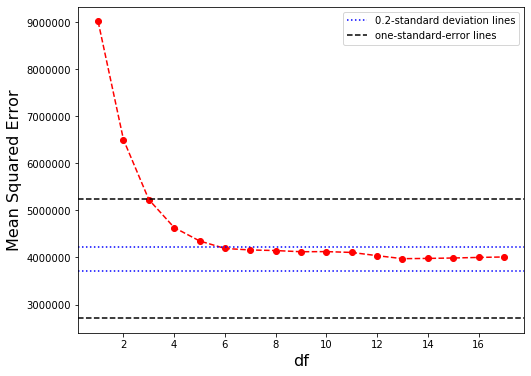

In [10]:
#如果直接使用最小则会产生过拟合的情况，故采用0.2-standard deviation或one-standard-error原则（原理参考6.1.3选择最优模型）
msr_array = np.array(msr_list) 
plt.figure(figsize=(8,6))
plt.plot(reg.index,msr_list,'r--o')
plt.xlabel('df',fontsize=16)
plt.ylabel('Mean Squared Error',fontsize=16)
plt.axhline(msr_array.min() + msr_array.std() * 0.2,color = 'b',linestyle = ':',label = '0.2-standard deviation lines')
plt.axhline(msr_array.min() - msr_array.std() * 0.2,color = 'b',linestyle = ':')
plt.axhline(msr_array.min() + msr_array.std() * 1,color = 'black',linestyle = '--',label = 'one-standard-error lines')
plt.axhline(msr_array.min() - msr_array.std() * 1,color = 'black',linestyle = '--')
plt.legend()
plt.show()

In [11]:
print('直接取最小值degree为:' , np.argmin(msr_array) + 1)
print('直接取最小值degree为:' , msr_list.index(min(msr_list)) + 1 )

直接取最小值degree为: 13
直接取最小值degree为: 13


In [12]:
#采用MSR的0.2-standard deviation（与BIC的0.2-standard deviation一致）6个特征值为模型
reg['X_columns'][6]

['Expend', 'Private[T.Yes]', 'Room_Board', 'perc_alumni', 'PhD', 'Grad_Rate']

**(b) Fit a GAM on the training data, using out-of-state tuition as
the response and the features selected in the previous step as
the predictors. Plot the results, and explain your findings.**

In [13]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(College_rename, test_size = 0.2, random_state = 1)

In [14]:
gam_fit = smf.ols( 'Outstate ~ Expend + Private + Room_Board + perc_alumni + PhD + Grad_Rate',data = train_set).fit()
gam_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Outstate   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     317.4
Date:                Mon, 06 Jan 2020   Prob (F-statistic):          1.78e-184
Time:                        14:10:24   Log-Likelihood:                -5594.4
No. Observations:                 621   AIC:                         1.120e+04
Df Residuals:                     614   BIC:                         1.123e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -4011.2363    495.565     -8.094      0.000   -4984.445   -3038.028
Private[T.Yes]  2915.7417    222.843     13.084      0.000    2478.114    3353.369
Expend             0.2031      0.019     10.438      0.000       0.165       0.241
Room_Board         1.0296      0.094     11.002      0.000       0.846       1.213
perc_alumni       48.1383      8.307      5.795      0.000      31.824      64.453
PhD               40.4792      6.189      6.541      0.000      28.326      52.633
Grad_Rate         28.0180      5.782      4.846      0.000      16.664      39.372
==============================================================================
Omnibus:                        1.627   Durbin-Watson:                   1.839
Prob(Omnibus):                  0.443   Jarque-Bera (JB):                1.462
Skew:                           0.070   Prob(JB):                        0.481
Kurtosis:                       3.192   Cond. No.                     7.37e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

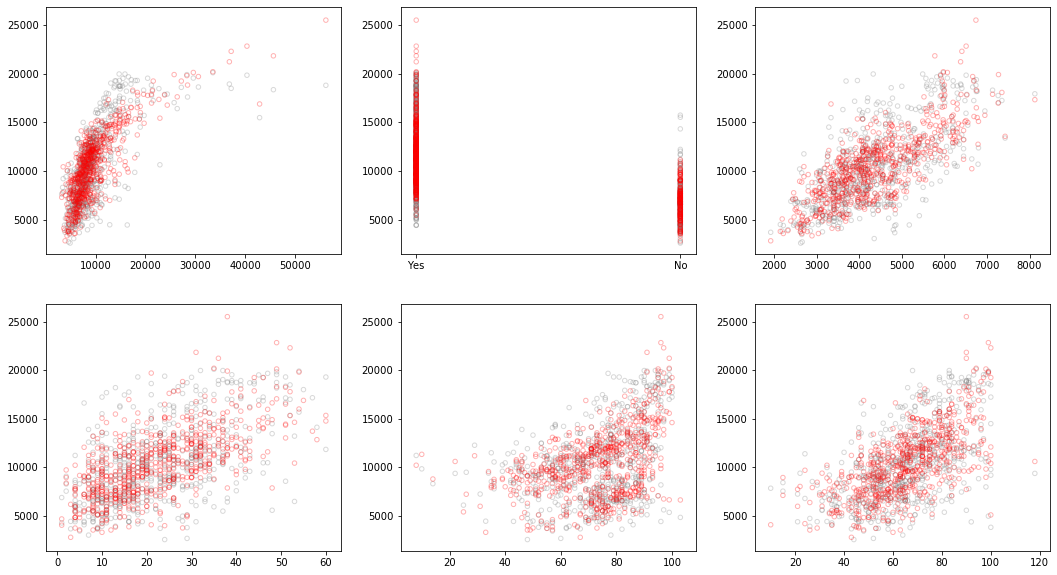

In [15]:
gam_predict = gam_fit.predict()
reg_select = ['Expend', 'Private', 'Room_Board', 'perc_alumni', 'PhD', 'Grad_Rate']
plt.figure(figsize=(18,10))
for select_num in range(6):
    select_factor = reg_select[select_num]
    plt.subplot(2,3,select_num + 1)
    plt.scatter(train_set[select_factor],train_set['Outstate'],color='', marker='o', edgecolors='gray', s=20,alpha = 0.3)
    plt.scatter(train_set[select_factor],gam_predict,color='', marker='o', edgecolors='red', s=20,alpha = 0.3)

从拟合结果上看比较接近

**(c) Evaluate the model obtained on the test set, and explain the
results obtained.**

In [16]:
gam_preds = gam_fit.predict(test_set)
gam_rss = np.sum((gam_preds - test_set['Outstate'])**2)
gam_mse = gam_rss/len(test_set)
gam_tss = np.sum((test_set['Outstate'] - test_set['Outstate'].mean())**2)
print('rss: ',gam_rss)
print('mse: ',gam_mse)
print('r-square: ',1 - gam_rss/gam_tss)

rss:  753467846.683795
mse:  4829922.09412689
r-square:  0.7096665376629454


解释了70%的方差。

**(d) For which variables, if any, is there evidence of a non-linear
relationship with the response?**

使用GridSearchCV（交叉验证网格搜索）实现

In [17]:
#数据预处理，这里使用pd.get_dummies进行哑变量变换
dummies = pd.get_dummies(train_set['Private'], prefix='Private')
train_set = train_set.join(dummies)
X_columns = ['Expend', 'Room_Board', 'perc_alumni', 'PhD', 'Grad_Rate','Private_Yes']
X = train_set[X_columns].values
y= train_set['Outstate'].values

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures
class CombinedPolyAll(BaseEstimator, TransformerMixin):
    def __init__(self,Expend_degree = 2,Room_Board_degree= 2,perc_alumni_degree= 2,
                PhD_degree= 2,Grad_Rate_degree= 2,Private_Yes_degree= 1): # no *args or **kargs
        self.Expend_degree = Expend_degree
        self.Room_Board_degree = Room_Board_degree
        self.perc_alumni_degree = perc_alumni_degree
        self.PhD_degree = PhD_degree
        self.Grad_Rate_degree = Grad_Rate_degree
        self.Private_Yes_degree = Private_Yes_degree
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        factor_degrees = [self.Expend_degree,self.Room_Board_degree,self.perc_alumni_degree,self.PhD_degree,
                         self.Grad_Rate_degree,self.Private_Yes_degree]
        for factor_num in range(6):
            X_factor = X[:,factor_num].reshape(-1, 1) 
            if factor_degrees[factor_num] > 0:
                poly_features = PolynomialFeatures(degree=factor_degrees[factor_num],include_bias=False)
                X_poly = poly_features.fit_transform(X_factor)
            else:
                X_poly = np.zeros_like(X_factor)
            if factor_num == 0:
                X_output = X_poly
            else:
                X_output = np.c_[X_output,X_poly]
        return X_output
cpa_lr = Pipeline([
("cpa", CombinedPolyAll()),
("lr", linear_model.LinearRegression())
])
param_grid = [
{'cpa__Expend_degree': np.arange(0,6),
 'cpa__Room_Board_degree': np.arange(0,6),
 'cpa__perc_alumni_degree': np.arange(0,6),
 'cpa__PhD_degree': np.arange(0,6),
 'cpa__Grad_Rate_degree': np.arange(0,6),
 'cpa__Private_Yes_degree': np.arange(0,2),
},
]
grid_search = GridSearchCV(cpa_lr, param_grid, cv = 10, scoring='neg_mean_squared_error')
grid_search.fit(X ,y)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cpa',
                                        CombinedPolyAll(Expend_degree=2,
                                                        Grad_Rate_degree=2,
                                                        PhD_degree=2,
                                                        Private_Yes_degree=1,
                                                        Room_Board_degree=2,
                                                        perc_alumni_degree=2)),
                                       ('lr',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated'

In [19]:
grid_search.best_params_

{'cpa__Expend_degree': 3,
 'cpa__Grad_Rate_degree': 1,
 'cpa__PhD_degree': 4,
 'cpa__Private_Yes_degree': 1,
 'cpa__Room_Board_degree': 1,
 'cpa__perc_alumni_degree': 1}

In [20]:
#对best_params_与单独变量Private，线性模型，以及随机取几个变量进行anova对比
def patsy_model_poly(factor,degree = 2):
    model_poly = factor
    for i in range(2,degree + 1):
        model_poly = model_poly + '+ I(' + factor +  '**{})'.format(str(i))
    return model_poly
fit_1 = smf.ols('Outstate ~ Private',data = train_set).fit()
fit_2 = smf.ols('Outstate ~ Expend + Private + Room_Board + perc_alumni + PhD + Grad_Rate',data = train_set).fit()
fit_3 = smf.ols('Outstate ~ Private +  Room_Board + Grad_Rate + perc_alumni + {} + {}'.format(patsy_model_poly('Expend',3),
                                                                        patsy_model_poly('PhD',4)),data = train_set).fit()
fit_4 = smf.ols('Outstate ~ Private + Room_Board + perc_alumni + {} + {} + {}'.format(patsy_model_poly('Expend',3),
                                                                        patsy_model_poly('Grad_Rate',3),
                                                                        patsy_model_poly('PhD',4)),data = train_set).fit()
sm.stats.anova_lm(fit_1,fit_2,fit_3,fit_4,typ=1)

c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,619.0,6.858174e+09,0.0,NaN,NaN,NaN
1,614.0,2.429126e+09,5.0,4.429048e+09,253.599648,1.030582e-146
2,609.0,2.132781e+09,5.0,2.963443e+08,16.968162,1.006905e-15
3,608.0,2.123711e+09,1.0,9.070902e+06,2.596921,1.075905e-01


best_params_ p值可信且RSS最小

In [21]:
gam_preds = fit_3.predict(test_set)
gam_rss = np.sum((gam_preds - test_set['Outstate'])**2)
gam_mse = gam_rss/len(test_set)
gam_tss = np.sum((test_set['Outstate'] - test_set['Outstate'].mean())**2)
print('rss: ',gam_rss)
print('mse: ',gam_mse)
print('r-square: ',1 - gam_rss/gam_tss)

rss:  638562970.8975005
mse:  4093352.3775480804
r-square:  0.7539427872378585


新模型解释了75%的方差，说明Expend、PhD为非线性关系。